<a href="https://colab.research.google.com/github/ChloeHuang1102/D2A_EV-Stock-Portflio-/blob/main/D2A_clean_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM-Robust投资组合系统

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cvxpy as cp
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("库导入完成")

库导入完成


## 1.历史数据获取

In [3]:
def get_ev_data_optimized(n_stocks=43, start_date='2020-01-01', end_date='2025-9-30'):
    """获取更多样化的EV股票数据"""
    print("="*50)
    print("1. 历史数据获取 - 优化版本")
    print("="*50)

    # 更稳定的EV股票池
    ev_stocks = [
        'TSLA', 'NIO', 'XPEV', 'LI', 'STLA', 'F', 'GM', 'VWAGY', 'HMC',
        'TM', 'RIVN', 'LCID', 'ALB', 'HON', 'SQM', 'QS', 'MVST', 'LAC',
        'JBL', 'CHPT', 'EVGO', 'BLNK', 'PLUG', 'BEEM', 'WBX', 'FOX', 'CENN', 'BIDU', 'KNDI', 'MGA', 'GELYF', 'AYRO',
        'TECK', 'POAHY', 'RNLSY', 'APTIV', 'BYDDY', 'BWA', 'HYLN', 'GP', 'NIU', 'ISUZY', 'MULN'
    ]

    stock_data = {}
    successful_stocks = []

    for symbol in ev_stocks[:n_stocks]:
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)

            if not data.empty and len(data) > 1000:  # 要求足够的历史数据
                stock_data[symbol] = data['Close']
                successful_stocks.append(symbol)
                print(f"✓ {symbol}: {len(data)} 个交易日")
            else:
                print(f"✗ {symbol}: 数据不足")
        except Exception as e:
            print(f"✗ {symbol}: 错误 - {e}")

    raw_data = pd.DataFrame(stock_data).dropna()
    returns = raw_data.pct_change().dropna()

    print(f"\n数据获取完成: {len(successful_stocks)} 支股票, {raw_data.shape[0]} 个交易日")
    return raw_data, returns, successful_stocks

# 获取数据
raw_data, returns, stock_names = get_ev_data_optimized()


1. 历史数据获取 - 优化版本
✓ TSLA: 1443 个交易日
✓ NIO: 1443 个交易日
✓ XPEV: 1278 个交易日
✓ LI: 1298 个交易日
✓ STLA: 1443 个交易日
✓ F: 1443 个交易日
✓ GM: 1443 个交易日
✓ VWAGY: 1443 个交易日
✓ HMC: 1443 个交易日
✓ TM: 1443 个交易日
✗ RIVN: 数据不足
✓ LCID: 1263 个交易日
✓ ALB: 1443 个交易日
✓ HON: 1443 个交易日
✓ SQM: 1443 个交易日
✓ QS: 1286 个交易日
✓ MVST: 1443 个交易日
✗ LAC: 数据不足
✓ JBL: 1443 个交易日
✓ CHPT: 1443 个交易日
✓ EVGO: 1218 个交易日
✓ BLNK: 1443 个交易日
✓ PLUG: 1443 个交易日
✓ BEEM: 1443 个交易日
✓ WBX: 1118 个交易日
✓ FOX: 1443 个交易日
✓ CENN: 1443 个交易日
✓ BIDU: 1443 个交易日
✓ KNDI: 1443 个交易日
✓ MGA: 1443 个交易日
✓ GELYF: 1443 个交易日
✓ AYRO: 1341 个交易日
✓ TECK: 1443 个交易日
✓ POAHY: 1443 个交易日
✓ RNLSY: 1443 个交易日


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: APTIV"}}}
ERROR:yfinance:$APTIV: possibly delisted; no timezone found


✗ APTIV: 数据不足
✓ BYDDY: 1443 个交易日
✓ BWA: 1443 个交易日
✓ HYLN: 1443 个交易日
✓ GP: 1277 个交易日


ERROR:yfinance:$MULN: possibly delisted; no timezone found


✓ NIU: 1443 个交易日
✓ ISUZY: 1443 个交易日
✗ MULN: 数据不足

数据获取完成: 39 支股票, 1118 个交易日


## 2.Preprocessing

In [4]:
print("="*50)
print("2. 数据预处理 - 优化版本")
print("="*50)

# 计算技术指标
def add_technical_indicators(data):
    """添加技术指标"""
    df = data.copy()

    # 移动平均线
    for window in [5, 10, 20, 50]:
        for col in df.columns:
            df[f'{col}_MA_{window}'] = df[col].rolling(window=window).mean()

    # RSI
    for col in df.columns:
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df[f'{col}_RSI'] = 100 - (100 / (1 + rs))

    # 波动率
    for col in df.columns:
        df[f'{col}_Volatility'] = df[col].rolling(window=20).std()

    return df

# 添加技术指标
enhanced_data = add_technical_indicators(raw_data)
enhanced_data = enhanced_data.dropna()

# 标准化 - 使用StandardScaler而不是MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(enhanced_data)
scaled_data = pd.DataFrame(scaled_data, columns=enhanced_data.columns, index=enhanced_data.index)

print(f"增强数据形状: {scaled_data.shape}")
print(f"收益率数据形状: {returns.shape}")
print("数据预处理完成")

2. 数据预处理 - 优化版本
增强数据形状: (1017, 2496)
收益率数据形状: (1117, 39)
数据预处理完成


## 3. Splitting

In [5]:
print("="*50)
print("3. 数据分割 - 优化版本")
print("="*50)

# 更合理的分割参数
test_size = 252  # 一年的交易日
val_size = 252   # 一年的验证期
sequence_length = 30  # 增加序列长度

# 分割数据
train_data = scaled_data.iloc[:-(test_size + val_size)]
val_data = scaled_data.iloc[-(test_size + val_size):-test_size]
test_data = scaled_data.iloc[-test_size:]

print(f"训练集: {train_data.shape}")
print(f"验证集: {val_data.shape}")
print(f"测试集: {test_data.shape}")
print(f"序列长度: {sequence_length}")
print("数据分割完成")

3. 数据分割 - 优化版本
训练集: (513, 2496)
验证集: (252, 2496)
测试集: (252, 2496)
序列长度: 30
数据分割完成


## 4.LSTM Model Training

In [6]:
print("="*50)
print("4. LSTM模型训练 - 优化版本")
print("="*50)

from tensorflow.keras.layers import BatchNormalization # Import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import callbacks

def prepare_lstm_data_enhanced(data, returns_data, seq_length):
    """准备增强的LSTM训练数据"""
    X, y = [], []
    # Ensure returns_data is aligned with data and has the same index
    aligned_returns = returns_data.loc[data.index]

    for i in range(seq_length, len(data)):
        X.append(data.iloc[i-seq_length:i].values)
        # The target variable y should be the returns for the next day
        # Use i directly on aligned_returns because it's aligned with data
        y.append(aligned_returns.iloc[i].values)
    return np.array(X), np.array(y)


def build_enhanced_lstm_model(input_shape, n_stocks):
    """构建增强的LSTM模型"""
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        # The output layer should predict the returns for n_stocks
        Dense(n_stocks, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    return model

# Prepare training data
# Pass returns data to prepare_lstm_data_enhanced
X_train, y_train = prepare_lstm_data_enhanced(train_data, returns, sequence_length)
X_val, y_val = prepare_lstm_data_enhanced(val_data, returns, sequence_length)

# Build and train the model
# Use the number of columns in the returns data as n_stocks
lstm_model = build_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]), returns.shape[1])

# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

print(f"训练数据形状: {X_train.shape}")
print(f"验证数据形状: {X_val.shape}")
print("开始训练增强LSTM模型...")

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("增强LSTM模型训练完成")

4. LSTM模型训练 - 优化版本
训练数据形状: (483, 30, 2496)
验证数据形状: (222, 30, 2496)
开始训练增强LSTM模型...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 706ms/step - loss: 0.7116 - mae: 0.6634 - val_loss: 0.0144 - val_mae: 0.0955 - learning_rate: 5.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - loss: 0.5318 - mae: 0.5760 - val_loss: 0.0112 - val_mae: 0.0834 - learning_rate: 5.0000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 647ms/step - loss: 0.4168 - mae: 0.5065 - val_loss: 0.0082 - val_mae: 0.0705 - learning_rate: 5.0000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - loss: 0.3343 - mae: 0.4521 - val_loss: 0.0069 - val_mae: 0.0644 - learning_rate: 5.0000e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - loss: 0.2765 - mae: 0.4120 - val_loss: 0.0064 - val_mae: 0.0617 - learning_rate: 5.0000e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - loss: 0.2472 - mae: 0.3876 - val_loss: 0.0067 - val_mae: 0.0630 - learning_rate: 5.0000e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/

## 5. Rolling window prediction

In [7]:
print("="*50)
print("5. 集成预测模型")
print("="*50)

from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor

def ensemble_prediction(lstm_model, data, seq_length, returns_data):
    """集成预测：LSTM + 随机森林"""
    predictions = []
    n_stocks = returns_data.shape[1]

    for i in range(seq_length, len(data)):
        window_data = data.iloc[i-seq_length:i]
        X_input = window_data.values.reshape(1, seq_length, -1)

        # LSTM预测 - now predicts returns directly
        lstm_pred = lstm_model.predict(X_input, verbose=0)[0]

        # Random Forest prediction (using historical returns)
        # We need at least 50 days of historical returns to train the RF model
        if i >= 50 + seq_length:
            # Historical returns data for RF training
            historical_returns = returns_data.iloc[i-50:i].values

            # X for RF: historical returns for the training window
            X_rf = historical_returns[:-1]
            # y for RF: returns on the day to predict (day i relative to the start of the test data)
            y_rf_all_stocks = historical_returns[-1] # Returns of all stocks on the prediction day

            rf_preds = []
            if X_rf.shape[0] > 10: # Ensure enough training samples for RF
                for stock_index in range(n_stocks):
                    # Train a separate RF model for each stock's return
                    # The target variable y_rf should be the historical returns for the current stock
                    y_rf_stock = X_rf[:, stock_index] # Historical returns for the current stock

                    rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
                    # Fit the RF model to predict the historical returns of a single stock
                    rf_model.fit(X_rf, y_rf_stock)

                    # Predict the return for the current day using the last day's historical returns of all stocks
                    rf_pred_stock = rf_model.predict(historical_returns[-1:].reshape(1, -1))[0]
                    rf_preds.append(rf_pred_stock)

                rf_pred = np.array(rf_preds)

                # Weighted average of LSTM and RF predictions (both are now predicting returns)
                final_pred = 0.7 * lstm_pred + 0.3 * rf_pred
            else:
                # If not enough data for RF, use only LSTM prediction
                final_pred = lstm_pred
        else:
             # If not enough data for RF, use only LSTM prediction
            final_pred = lstm_pred


        predictions.append(final_pred)

    return np.array(predictions)

# Execute ensemble prediction
# Pass the original returns data to the ensemble_prediction function
ensemble_predictions = ensemble_prediction(lstm_model, test_data, sequence_length, returns)


print(f"集成预测结果形状: {ensemble_predictions.shape}")
print("集成预测完成")

5. 集成预测模型
集成预测结果形状: (222, 39)
集成预测完成


## 6. Quantify Uncertainty

In [8]:
print("="*50)
print("6. 不确定性量化 - 优化版本")
print("="*50)

def quantify_uncertainty_enhanced(model, test_data, seq_length, n_samples=50):
    """增强的不确定性量化"""
    predictions_list = []

    for i in range(seq_length, len(test_data)):
        window_data = test_data.iloc[i-seq_length:i]
        X_input = window_data.values.reshape(1, seq_length, -1)

        # 多次预测（Monte Carlo Dropout）
        pred_samples = []
        for _ in range(n_samples):
            pred = model.predict(X_input, verbose=0)
            pred_samples.append(pred[0])

        pred_samples = np.array(pred_samples)
        mean_pred = np.mean(pred_samples, axis=0)
        uncertainty = np.std(pred_samples, axis=0)

        # 添加历史波动率作为额外的不确定性
        if i > 20:
            historical_vol = returns.iloc[i-20:i].std().values
            uncertainty = np.maximum(uncertainty, historical_vol * 0.5)

        predictions_list.append((mean_pred, uncertainty))

    return predictions_list

# 量化不确定性
uncertainty_results = quantify_uncertainty_enhanced(lstm_model, test_data, sequence_length)

mean_predictions = np.array([result[0] for result in uncertainty_results])
uncertainties = np.array([result[1] for result in uncertainty_results])

print(f"平均预测形状: {mean_predictions.shape}")
print(f"不确定性形状: {uncertainties.shape}")
print("不确定性量化完成")


6. 不确定性量化 - 优化版本
平均预测形状: (222, 39)
不确定性形状: (222, 39)
不确定性量化完成


## 7. Robust Optimization

In [9]:
print("="*50)
print("7. Robust优化 - 优化版本")
print("="*50)

def robust_optimization_enhanced(expected_returns, uncertainty, cov_matrix,
                                risk_aversion=2.0, uncertainty_factor=0.2,
                                max_weight=0.15, min_weight=0.01):
    """增强的Robust Mean-Variance优化"""
    n = len(expected_returns)
    weights = cp.Variable(n)

    # 考虑不确定性的鲁棒收益
    robust_returns = expected_returns - uncertainty_factor * uncertainty

    # 目标函数
    portfolio_return = cp.sum(cp.multiply(weights, robust_returns))
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    objective = cp.Maximize(portfolio_return - risk_aversion * portfolio_risk)

    # 约束条件
    constraints = [
        cp.sum(weights) == 1,  # 权重和为1
        weights >= min_weight,  # 最小权重
        weights <= max_weight,  # 最大权重
    ]

    # 添加风险预算约束
    risk_budget = cp.sum(cp.multiply(weights, cp.diag(cov_matrix)))
    constraints.append(risk_budget <= 0.1)  # 风险预算限制

    # 求解
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        return weights.value
    else:
        # 如果优化失败，使用风险平价
        inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
        weights_equal_risk = inv_vol / np.sum(inv_vol)
        return weights_equal_risk

print("增强Robust优化函数定义完成")


7. Robust优化 - 优化版本
增强Robust优化函数定义完成


## 8.投资组合权重

In [10]:
print("="*50)
print("8. 投资组合权重计算")
print("="*50)

# 计算协方差矩阵（使用更长的历史数据）
cov_matrix = returns.iloc[-500:].cov().values  # 使用最近500个交易日

# 为每个预测时点计算最优权重
portfolio_weights = []

for i in range(len(mean_predictions)):
    expected_returns = mean_predictions[i]
    uncertainty = uncertainties[i]

    # 增强Robust优化
    optimal_weights = robust_optimization_enhanced(
        expected_returns, uncertainty, cov_matrix,
        risk_aversion=2.0, uncertainty_factor=0.2
    )
    portfolio_weights.append(optimal_weights)

portfolio_weights = np.array(portfolio_weights)

print(f"投资组合权重形状: {portfolio_weights.shape}")
print(f"权重和: {portfolio_weights.sum(axis=1)[:5]}...")
print("投资组合权重计算完成")


8. 投资组合权重计算
投资组合权重形状: (222, 39)
权重和: [1. 1. 1. 1. 1.]...
投资组合权重计算完成


## 9. 回测评估

In [12]:
print("="*50)
print("9. 回测评估")
print("="*50)

# 计算投资组合收益率
portfolio_returns = []
actual_returns = returns.iloc[-len(portfolio_weights):].values

for i, weights in enumerate(portfolio_weights):
    if i < len(actual_returns):
        portfolio_return = np.dot(weights, actual_returns[i])
        portfolio_returns.append(portfolio_return)

portfolio_returns = np.array(portfolio_returns)

# 计算性能指标
total_return = (1 + portfolio_returns).prod() - 1
volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# 最大回撤
cumulative = (1 + portfolio_returns).cumprod()
# Convert cumulative to a pandas Series to use .expanding()
cumulative_series = pd.Series(cumulative)
running_max = cumulative_series.expanding().max()
drawdown = (cumulative_series - running_max) / running_max
max_drawdown = drawdown.min()

# 计算其他指标
win_rate = (portfolio_returns > 0).mean()
avg_win = portfolio_returns[portfolio_returns > 0].mean() if (portfolio_returns > 0).any() else 0
avg_loss = portfolio_returns[portfolio_returns < 0].mean() if (portfolio_returns < 0).any() else 0
profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0

print(f"投资组合收益率形状: {portfolio_returns.shape}")
print("回测评估完成")

9. 回测评估
投资组合收益率形状: (222,)
回测评估完成


## 10.性能报告

10. Performance Report - Optimized Version
Investment Universe: 39 Stocks
Testing Period: 222 Trading Days
Sequence Length: 30 Days

------------------------------------------------------------
Performance Metrics
------------------------------------------------------------
• Total Return: 0.2621 (26.21%)
• Annualized Volatility: 0.3661 (36.61%)
• Sharpe Ratio: 0.8984
• Max Drawdown: -0.2542 (-25.42%)
• Win Rate: 0.5495 (54.95%)
• Profit Factor: 0.9752

------------------------------------------------------------
Model Characteristics
------------------------------------------------------------
• Enhanced LSTM: Deeper Network + Batch Normalization
• Ensemble Prediction: LSTM + Random Forest
• Technical Indicators: Moving Average + RSI + Volatility
• Risk Control: Weight Constraints + Risk Budgeting
• Uncertainty: Monte Carlo Dropout


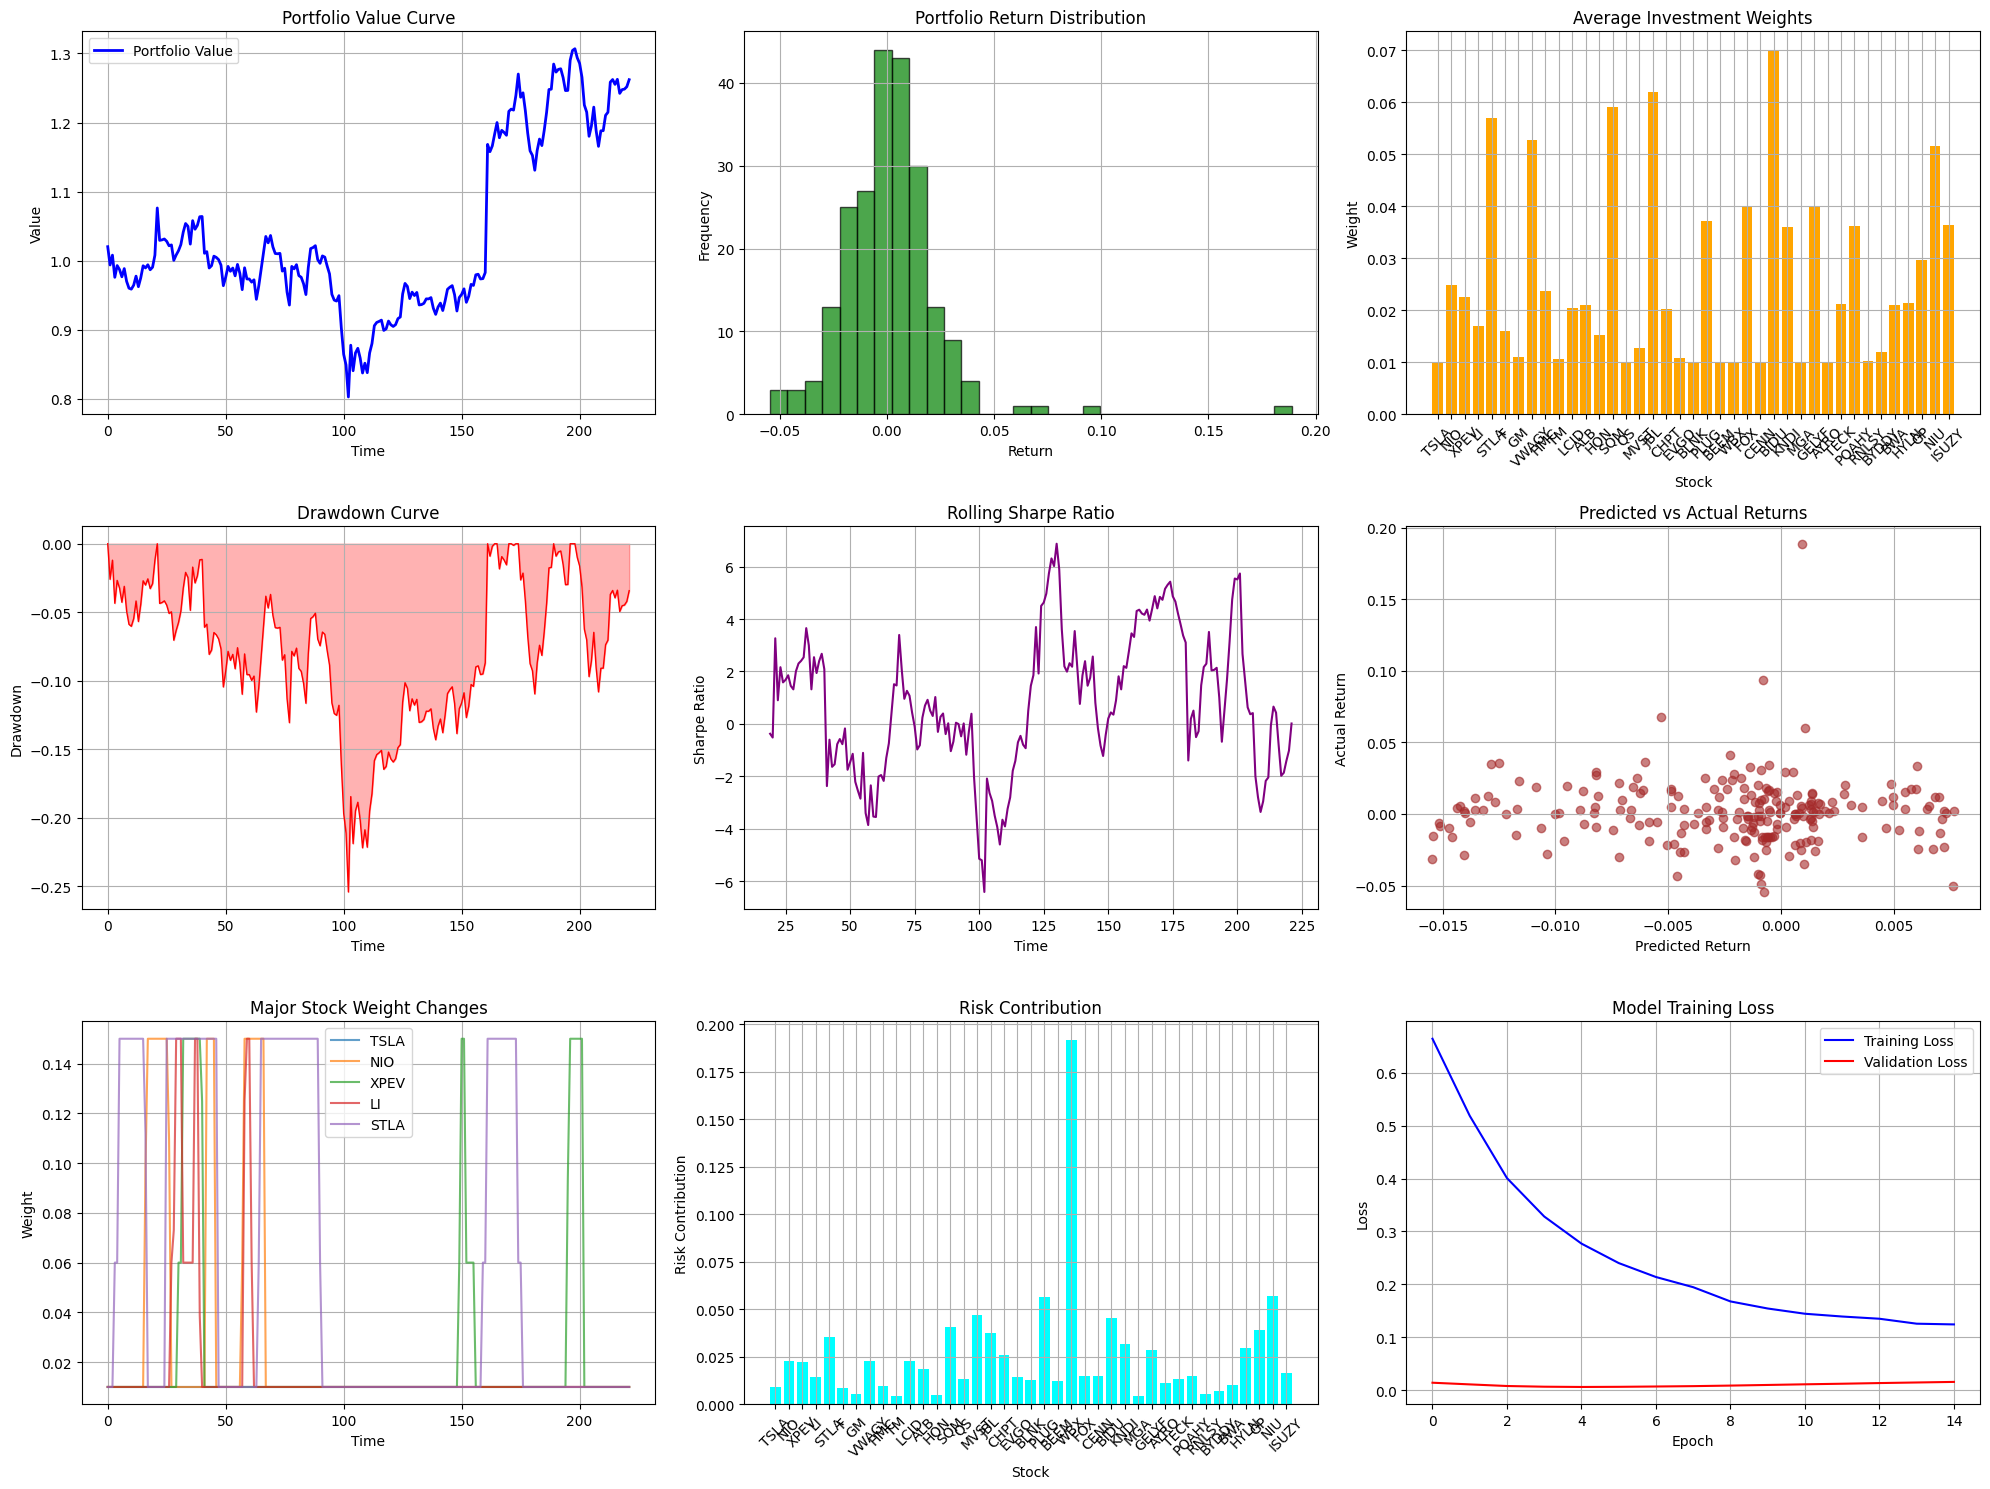


Performance Report Complete!


In [13]:
print("="*60)
print("10. Performance Report - Optimized Version")
print("="*60)

print(f"Investment Universe: {len(stock_names)} Stocks")
print(f"Testing Period: {len(portfolio_returns)} Trading Days")
print(f"Sequence Length: {sequence_length} Days")

print("\n" + "-"*60)
print("Performance Metrics")
print("-"*60)
print(f"• Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"• Annualized Volatility: {volatility:.4f} ({volatility*100:.2f}%)")
print(f"• Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"• Max Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
print(f"• Win Rate: {win_rate:.4f} ({win_rate*100:.2f}%)")
print(f"• Profit Factor: {profit_factor:.4f}")

print("\n" + "-"*60)
print("Model Characteristics")
print("-"*60)
print("• Enhanced LSTM: Deeper Network + Batch Normalization")
print("• Ensemble Prediction: LSTM + Random Forest")
print("• Technical Indicators: Moving Average + RSI + Volatility")
print("• Risk Control: Weight Constraints + Risk Budgeting")
print("• Uncertainty: Monte Carlo Dropout")

# 可视化结果
plt.figure(figsize=(20, 15))

# 投资组合价值曲线
plt.subplot(3, 3, 1)
portfolio_values = (1 + portfolio_returns).cumprod()
plt.plot(portfolio_values, label='Portfolio Value', linewidth=2, color='blue')
plt.title('Portfolio Value Curve')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# 收益率分布
plt.subplot(3, 3, 2)
plt.hist(portfolio_returns, bins=30, alpha=0.7, edgecolor='black', color='green')
plt.title('Portfolio Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)

# 权重分布
plt.subplot(3, 3, 3)
avg_weights = portfolio_weights.mean(axis=0)
plt.bar(range(len(stock_names)), avg_weights, color='orange')
plt.title('Average Investment Weights')
plt.xlabel('Stock')
plt.ylabel('Weight')
plt.xticks(range(len(stock_names)), stock_names, rotation=45)
plt.grid(True)

# 回撤曲线
plt.subplot(3, 3, 4)
plt.fill_between(range(len(drawdown)), drawdown, 0, alpha=0.3, color='red')
plt.plot(drawdown, color='red', linewidth=1)
plt.title('Drawdown Curve')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.grid(True)

# 滚动夏普比率
plt.subplot(3, 3, 5)
rolling_sharpe = pd.Series(portfolio_returns).rolling(window=20).mean() / pd.Series(portfolio_returns).rolling(window=20).std() * np.sqrt(252)
plt.plot(rolling_sharpe, color='purple')
plt.title('Rolling Sharpe Ratio')
plt.xlabel('Time')
plt.ylabel('Sharpe Ratio')
plt.grid(True)

# 预测vs实际
plt.subplot(3, 3, 6)
if len(mean_predictions) > 0:
    plt.scatter(mean_predictions.mean(axis=1), portfolio_returns, alpha=0.6, color='brown')
    plt.title('Predicted vs Actual Returns')
    plt.xlabel('Predicted Return')
    plt.ylabel('Actual Return')
    plt.grid(True)

# 权重时间序列
plt.subplot(3, 3, 7)
for i in range(min(5, len(stock_names))):
    plt.plot(portfolio_weights[:, i], label=stock_names[i], alpha=0.7)
plt.title('Major Stock Weight Changes')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)

# 风险贡献
plt.subplot(3, 3, 8)
risk_contrib = portfolio_weights * np.sqrt(np.diag(cov_matrix))
risk_contrib = risk_contrib / risk_contrib.sum(axis=1, keepdims=True)
plt.bar(range(len(stock_names)), risk_contrib.mean(axis=0), color='cyan')
plt.title('Risk Contribution')
plt.xlabel('Stock')
plt.ylabel('Risk Contribution')
plt.xticks(range(len(stock_names)), stock_names, rotation=45)
plt.grid(True)

# 模型损失曲线
plt.subplot(3, 3, 9)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nPerformance Report Complete!")